In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba
import pandas as pd
from scipy import stats
import gzip
import urllib.request
from string import punctuation
from collections import Counter
from fractions import Fraction

In [2]:
def analyze_word_counts(word_counts):
    df = pd.DataFrame(word_counts, columns=["word", "count"])
    print(df["word"].unique().shape)
    total_words = df["count"].sum()
    unique_words = len(word_counts)
    print("Total words: %d"%total_words)
    print("Total unique words: %d"%unique_words)
    print("$\\rho_{est} =  %.3f$"%(unique_words/total_words))

    print("\\begin{enumerate}")
    for i in range(1,3+1):
        count = df[df["count"] == i].shape
        print("\t\\item There were %5d (%.3f\\%%) words used %d times each"%(count[0], count[0]*100/ unique_words,   i))
    print("\\end{enumerate}")

In [3]:
ulysses_url = "http://www.uvm.edu/pdodds/teaching/courses/2020-08UVM-300/docs/ulysses.txt"
def generate_word_counts_ulysses():
    print("Running for Ulysses...")
    with urllib.request.urlopen(ulysses_url) as f:
        word_counts =  [tuple(l.split()) for l in f.read().decode("utf-8").split("\n") if l != ""]
    word_counts = [(a[:-1], int(b)) for (a,b) in word_counts]
    return word_counts

In [4]:
analyze_word_counts(generate_word_counts_ulysses())

Running for Ulysses...
(31398,)
Total words: 264706
Total unique words: 31398
$\rho_{est} =  0.119$
\begin{enumerate}
	\item There were 17738 (56.494\%) words used 1 times each
	\item There were  4887 (15.565\%) words used 2 times each
	\item There were  2241 (7.137\%) words used 3 times each
\end{enumerate}


In [5]:
pride_and_prejudice_url = "https://www.gutenberg.org/files/1342/1342-0.txt"
def generate_word_counts_pride_prejudice():
    print("Running for Pride and Prejudice...")
    with urllib.request.urlopen(pride_and_prejudice_url) as f:
        raw = f.read().decode("utf-8")
    
    exclude = set(punctuation) 

    raw_trimmed = raw.split("\r\n")[35:-368] # remove boilerplate content
    raw_joined = " ".join(raw_trimmed)
    list_letters_noPunct =  [ char for char in raw_joined if char not in exclude ]
    text_noPunct = "".join(list_letters_noPunct)
    list_words = text_noPunct.strip().split()
    words_counter = Counter(list_words)
    
    return(list(words_counter.items()))

In [6]:
analyze_word_counts(generate_word_counts_pride_prejudice())

Running for Pride and Prejudice...
(8206,)
Total words: 121662
Total unique words: 8206
$\rho_{est} =  0.067$
\begin{enumerate}
	\item There were  3668 (44.699\%) words used 1 times each
	\item There were  1218 (14.843\%) words used 2 times each
	\item There were   689 (8.396\%) words used 3 times each
\end{enumerate}


In [7]:
le_comte_urls = ["https://www.gutenberg.org/ebooks/17989.txt.utf-8", # volume 1 - 4
                "https://www.gutenberg.org/ebooks/17990.txt.utf-8",
                "https://www.gutenberg.org/ebooks/17991.txt.utf-8",
                "https://www.gutenberg.org/ebooks/17992.txt.utf-8"]
exclude = set(punctuation) 

def generate_word_counts_le_comte():
    print("Running for Le comte...")
    raws = [urllib.request.urlopen(url).read().decode("utf-8") for url in le_comte_urls]
    raws_trimmed = [raw.split("\r\n")[25: -368] for raw in raws] # remove boilerplate code
    raws_joined = []
    for raw in raws_trimmed:
        raws_joined += raw
    list_letters_noPunct =  [ char for char in raws_joined if char not in exclude ]
    text_noPunct = "".join(list_letters_noPunct)
    list_words = text_noPunct.strip().split()
    words_counter = Counter(list_words)
    
    return(list(words_counter.items()))

In [8]:
analyze_word_counts(generate_word_counts_le_comte())

Running for Le comte...
(76625,)
Total words: 420611
Total unique words: 76625
$\rho_{est} =  0.182$
\begin{enumerate}
	\item There were 57981 (75.669\%) words used 1 times each
	\item There were  7287 (9.510\%) words used 2 times each
	\item There were  3113 (4.063\%) words used 3 times each
\end{enumerate}


In [9]:
words, counts = zip(*generate_word_counts_le_comte())

Running for Le comte...


(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbb5c393350>)

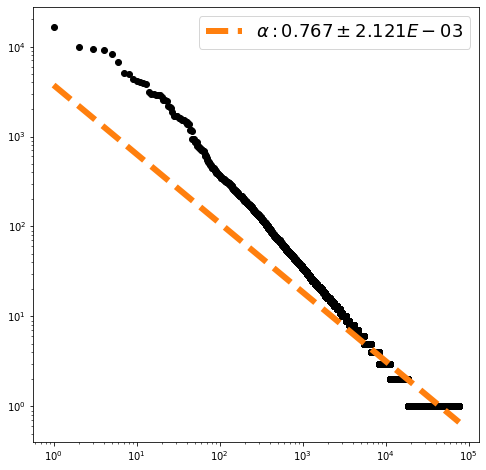

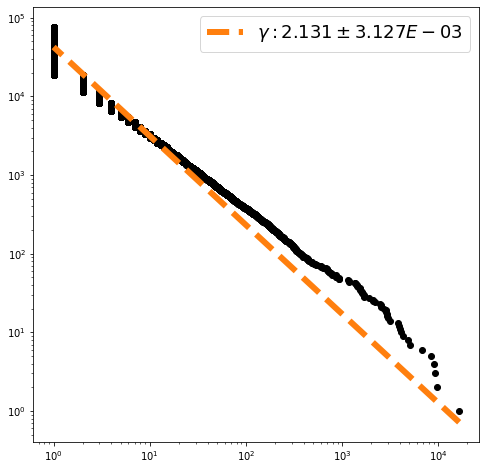

In [10]:
def plot_ZIPF(samples, title="", xlabel="", ylabel="", save=None, split_point=None):
    N = len(samples)
    Y = np.array(sorted(samples, reverse=True))
    X = np.arange(1, N+1)
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.scatter(X, Y, c="k")
    
    if split_point is not None:
        mask = (split_point < X)
        X_sub = X[mask]
        Y_sub = Y[mask]
        
        log10_X_sub = np.log10(X_sub)
        log10_Y_sub = np.log10(Y_sub)
        slope, intercept, r_val, p_val, std_err = stats.linregress(log10_X_sub, log10_Y_sub)
        predict = lambda n: intercept + slope * n 
        predictions = np.power(10, predict(log10_X_sub))
        ax.plot(X_sub, predictions, c="C1", linewidth=6, linestyle="dashed", label=r"$\alpha: %.3f \pm %.3E$"%((-1 * slope), std_err * 1.96))
           
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(title, fontsize=24)
    if split_point is not None:
        ax.legend(fontsize=18)
    return fig, ax
def plot_CCDF(samples, title="", xlabel="", ylabel="", save=None, scaling_range=None):
    N = len(samples)
    X = np.array(sorted(samples, reverse=True))
    Y = np.arange(1, N+1)
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.scatter(X, Y, c="k")
    
    if scaling_range is not None:
        mask = (scaling_range[0] < X) & (X < scaling_range[1])
        X_sub = X[mask]
        Y_sub = Y[mask]
        
        log10_X_sub = np.log10(X_sub)
        log10_Y_sub = np.log10(Y_sub)
        slope, intercept, r_val, p_val, std_err = stats.linregress(log10_X_sub, log10_Y_sub)
        predict = lambda n: intercept + slope * n 
        predictions = np.power(10, predict(log10_X_sub))
        ax.plot(X_sub, predictions, c="C1", linewidth=6, linestyle="dashed", label=r"$\gamma: %.3f \pm %.3E$"%((-slope + 1), std_err * 1.96))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_title(title, fontsize=24)
    if scaling_range is not None:
        ax.legend(fontsize=18)
    return fig, ax

plot_ZIPF(counts, split_point=0)
plot_CCDF(counts, scaling_range=[0, 1e100])